In [ ]:
!pip install np_utils

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for np_utils: filename=np_utils-0.6.0-py3-none-any.whl size=56438 sha256=bcf1b27de03a70d87b37de3fbd65afd3fe93f9e40a6ae7b5c91832cdbc28fa66
  Stored in directory: /root/.cache/pip/wheels/b6/c7/50/2307607f44366dd021209f660045f8d51cb976514d30be7cc7
Successfully built np_utils


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import pickle as pkl
from tensorflow import keras
import tensorflow.keras.backend as K
from keras.models import Sequential,Model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Input, Reshape, BatchNormalization, Bidirectional, LSTM, Multiply, Activation, Normalization, TimeDistributed
from keras.layers import Conv3D, Conv2D, Conv1D, MaxPool3D, MaxPool2D, MaxPool1D, AvgPool3D, AvgPool2D, AvgPool1D, GlobalMaxPool3D, Attention, Subtract
from keras.layers import GlobalMaxPool2D, GlobalMaxPool1D, SpatialDropout3D, SpatialDropout2D, SpatialDropout1D, GlobalAvgPool3D, MultiHeadAttention
from keras.layers import GlobalAvgPool2D, GlobalAvgPool1D, SeparableConv2D, SeparableConv1D, Add, Concatenate, LeakyReLU, ELU, Activation, PReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
# from keras.utils import np_utils
from keras import utils
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_recall_fscore_support
from sklearn.utils.class_weight import compute_class_weight
import gc

# **Data Loading**

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
gc.collect()

Mounted at /content/drive/


0

In [ ]:
# /content/drive/MyDrive/data_preprocessed_python/
input_path='/content/drive/MyDrive/Colab Notebooks/KdHinton/data_preprocessed_python/'

In [ ]:
def baseline_remove(XR):
  XT = XR[:, 384:]
  XB_ = (XR[:, :1*128] + XR[:, 1*128:2*128] + XR[:, 2*128:3*128])/3.0
  for i in range(60):
    XT[:, i*128:(i+1)*128] = XT[:, i*128:(i+1)*128] - XB_
  return XT


In [ ]:
new_channels = [0,1,18,2,3,5,4,23,6,7,9,8,15,10,11,12,14,13,
 16,17,18,19,20,22,21,23,24,25,27,26,15,28,29,30,14,31]

In [ ]:
eeg_signal = []
#valence = []
#arousal = []
window_size = 256
no_channels = 32
no_new_channels = len(new_channels)
no_videos = 40
Trsld = 5
va = []

for person in range(1,33):
  print('Person No.' + str(person))


  # EEG files address
  if person < 10 :
    address = input_path+'s0'+str(person)+'.dat'
  else :
    address = input_path+'s'+str(person)+'.dat'

  with open(address, 'rb') as file:
    data = pkl.load(file, encoding = 'latin1')

  eeg = data['data']
  label = data['labels']

  # Assigning classes
  valaro = np.array([0 if label[i, 0] < Trsld and label[i, 1] < Trsld else 1 if label[i, 0] < Trsld and label[i, 1] >= Trsld
                     else 2 if label[i, 0] >= Trsld and label[i, 1] < Trsld else 3 for i in range(40)])

  del data, label
  # Iterating through 40 vidoes/trials
  for i in range(no_videos):
    sig = eeg[i][:no_channels, :]
    sig = baseline_remove(sig)
    temp = []
    for j in new_channels:
      temp.append(sig[j, :])
    sig = np.reshape(temp,[no_new_channels,-1])
    # Segmenting into 2 seconds (256 timesteps) windows without overlap
    start = 0
    while start + window_size <=sig.shape[1]:
      eeg_signal.append(sig[:, start:start+window_size])
      va.append(valaro[i])
      start += window_size
  del eeg, valaro, sig
eeg_signal = np.reshape(eeg_signal,[-1,no_new_channels,window_size])
data = np.asarray(eeg_signal, dtype = np.float32) # Using 32 bit floating point value to save memory
del eeg_signal
va = np.asarray(va, dtype = np.int8)

print(data.shape)
print(va.shape, va[va == 0].shape, va[va == 1].shape, va[va == 2].shape, va[va == 3].shape)

va = utils.to_categorical(va)
gc.collect()

Person No.1


FileNotFoundError: ignored

In [ ]:
def simple_2D_CNN(x):

  y = AvgPool2D(pool_size=(1,256))(x)
  y = Flatten()(y)
  y = Dense(4,activation='tanh') (y)
  y = Dense(36,activation='softmax') (y)
  x = Multiply()([x, tf.expand_dims(tf.expand_dims(y, axis=2), axis=2)])
  x1 = Conv2D(filters = 16, kernel_size = (1,16), strides = (1,1), padding = 'same', activation='selu')(x) #above 8 Hz
  x2 = Conv2D(filters = 16, kernel_size = (1,10), strides = (1,1), padding = 'same', activation='selu')(x) #above 12.8 Hz
  x3 = Conv2D(filters = 16, kernel_size = (1,6), strides = (1,1), padding = 'same', activation='selu')(x) #above 21.3 Hz
  x1 = Subtract()([x1, x2]) #above 8 Hz and below 12.8 Hz
  x1 = MaxPool2D(pool_size=(1,2))(x1) #downsampling by 2
  x1 = Conv2D(filters = 16, kernel_size = (1,16), strides = (1,1), padding = 'same', activation='selu')(x1)
  x1 = MaxPool2D(pool_size=(1,2))(x1)
  x1 = Conv2D(filters = 16, kernel_size = (1,16), strides = (1,1), padding = 'same', activation='selu')(x1)
  x1 = MaxPool2D(pool_size=(1,2))(x1)
  x2 = Subtract()([x2, x3]) #above 12.8 Hz and below 21.3 Hz
  x2 = MaxPool2D(pool_size=(1,2))(x2)
  x2 = Conv2D(filters = 16, kernel_size = (1,10), strides = (1,1), padding = 'same', activation='selu')(x2)
  x2 = MaxPool2D(pool_size=(1,2))(x2)
  x2 = Conv2D(filters = 16, kernel_size = (1,10), strides = (1,1), padding = 'same', activation='selu')(x2)
  x2 = MaxPool2D(pool_size=(1,2))(x2)
  x = Concatenate(axis=3)([x1, x2])
  x = Dropout(0.1)(x)
  x1 = Conv2D(filters = 32, kernel_size = (2,4), strides = (2,1), padding = 'same', activation='selu')(x)
  x1 = Conv2D(filters = 32, kernel_size = (3,4), strides = (3,1), padding = 'same', activation='selu')(x1)
  x1 = Conv2D(filters = 32, kernel_size = (3,4), strides = (3,1), padding = 'same', activation='selu')(x1)
  x1 = MaxPool2D(pool_size=(1,2))(x1)
  x2 = Conv2D(filters = 32, kernel_size = (3,4), strides = (3,1), padding = 'same', activation='selu')(x)
  x2 = Conv2D(filters = 32, kernel_size = (2,4), strides = (2,1), padding = 'same', activation='selu')(x2)
  x2 = Conv2D(filters = 32, kernel_size = (3,4), strides = (3,1), padding = 'same', activation='selu')(x2)
  x2 = MaxPool2D(pool_size=(1,2))(x2)
  x3 = Conv2D(filters = 32, kernel_size = (6,4), strides = (6,1), padding = 'same', activation='selu')(x)
  x3 = Conv2D(filters = 32, kernel_size = (3,4), strides = (3,1), padding = 'same', activation='selu')(x3)
  x3 = MaxPool2D(pool_size=(1,2))(x3)
  x4 = Conv2D(filters = 32, kernel_size = (9,4), strides = (9,1), padding = 'same', activation='selu')(x)
  x4 = Conv2D(filters = 32, kernel_size = (2,4), strides = (2,1), padding = 'same', activation='selu')(x4)
  x4 = MaxPool2D(pool_size=(1,2))(x4)
  x5 = Conv2D(filters = 32, kernel_size = (18,4), strides = (18,1), padding = 'same', activation='selu')(x)
  x5 = MaxPool2D(pool_size=(1,2))(x5)
  x = Concatenate(axis=3)([x1, x2, x3, x4, x5])
  x = Dropout(0.1)(x)
  x = Conv2D(filters = x.shape[3], kernel_size = (2,2), strides = (2,1), padding = 'same', activation='selu')(x)
  x = GlobalAvgPool2D()(x)
  x = Dense(128, activation='tanh')(x)
  x = Dropout(0.1)(x)
  x = Dense(32, activation='relu')(x)
  x = Dropout(0.1)(x)
  x = Dense(4, activation='softmax')(x)
  return x

def get_model():
  input_shape = (36, 256, 1)
  a = Input(input_shape)
  out = simple_2D_CNN(a)
  model = Model(a, out)
  opt = keras.optimizers.Adam(learning_rate=1e-04)
  model.compile(loss=keras.losses.categorical_crossentropy, metrics=["accuracy"], optimizer=opt)
  return model
model = get_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 36, 256, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 average_pooling2d (AveragePool  (None, 36, 1, 1)    0           ['input_1[0][0]']                
 ing2D)                                                                                           
                                                                                                  
 flatten (Flatten)              (None, 36)           0           ['average_pooling2d[0][0]']      
                                                                                              

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=False)

In [ ]:
# Tan's Model
def simple_2D_CNN_tan(x):
  y = AvgPool2D(pool_size=(1,256))(x)
  y = Flatten()(y)
  y = Dense(4,activation='tanh') (y)
  y = Dense(36,activation='softmax') (y)
  x = Multiply()([x, tf.expand_dims(tf.expand_dims(y, axis=2), axis=2)])
  x1 = Conv2D(filters = 16, kernel_size = (1,16), strides = (1,1), padding = 'same', activation='selu')(x) #above 8 Hz
  x2 = Conv2D(filters = 16, kernel_size = (1,10), strides = (1,1), padding = 'same', activation='selu')(x) #above 12.8 Hz
  x3 = Conv2D(filters = 16, kernel_size = (1,6), strides = (1,1), padding = 'same', activation='selu')(x) #above 21.3 Hz
  x1 = Subtract()([x1, x2]) #above 8 Hz and below 12.8 Hz
  x1 = MaxPool2D(pool_size=(1,2))(x1) #downsampling by 2
  x1 = Conv2D(filters = 16, kernel_size = (1,16), strides = (1,1), padding = 'same', activation='selu')(x1)
  x1 = MaxPool2D(pool_size=(1,2))(x1)
  x1 = Conv2D(filters = 16, kernel_size = (1,16), strides = (1,1), padding = 'same', activation='selu')(x1)
  x1 = MaxPool2D(pool_size=(1,2))(x1)
  x2 = Subtract()([x2, x3]) #above 12.8 Hz and below 21.3 Hz
  x2 = MaxPool2D(pool_size=(1,2))(x2)
  x2 = Conv2D(filters = 16, kernel_size = (1,10), strides = (1,1), padding = 'same', activation='selu')(x2)
  x2 = MaxPool2D(pool_size=(1,2))(x2)
  x2 = Conv2D(filters = 16, kernel_size = (1,10), strides = (1,1), padding = 'same', activation='selu')(x2)
  x2 = MaxPool2D(pool_size=(1,2))(x2)
  x = Concatenate(axis=3)([x1, x2])
  x = Dropout(0.1)(x)
  x1 = Conv2D(filters = 32, kernel_size = (2,4), strides = (2,1), padding = 'same', activation='selu')(x)
  x1 = Conv2D(filters = 32, kernel_size = (3,4), strides = (3,1), padding = 'same', activation='selu')(x1)
  x1 = Conv2D(filters = 32, kernel_size = (3,4), strides = (3,1), padding = 'same', activation='selu')(x1)
  x1 = MaxPool2D(pool_size=(1,2))(x1)
  x2 = Conv2D(filters = 32, kernel_size = (3,4), strides = (3,1), padding = 'same', activation='selu')(x)
  x2 = Conv2D(filters = 32, kernel_size = (2,4), strides = (2,1), padding = 'same', activation='selu')(x2)
  x2 = Conv2D(filters = 32, kernel_size = (3,4), strides = (3,1), padding = 'same', activation='selu')(x2)
  x2 = MaxPool2D(pool_size=(1,2))(x2)
  x3 = Conv2D(filters = 32, kernel_size = (6,4), strides = (6,1), padding = 'same', activation='selu')(x)
  x3 = Conv2D(filters = 32, kernel_size = (3,4), strides = (3,1), padding = 'same', activation='selu')(x3)
  x3 = MaxPool2D(pool_size=(1,2))(x3)
  x4 = Conv2D(filters = 32, kernel_size = (9,4), strides = (9,1), padding = 'same', activation='selu')(x)
  x4 = Conv2D(filters = 32, kernel_size = (2,4), strides = (2,1), padding = 'same', activation='selu')(x4)
  x4 = MaxPool2D(pool_size=(1,2))(x4)
  x5 = Conv2D(filters = 32, kernel_size = (18,4), strides = (18,1), padding = 'same', activation='selu')(x)
  x5 = MaxPool2D(pool_size=(1,2))(x5)
  x = Concatenate(axis=3)([x1, x2, x3, x4, x5])
  x = Dropout(0.1)(x)
  x = Conv2D(filters = x.shape[3], kernel_size = (2,2), strides = (2,1), padding = 'same', activation='selu')(x)
  x = GlobalAvgPool2D()(x)
  x = Dense(128, activation='tanh')(x)
  x = Dropout(0.1)(x)
  x = Dense(32, activation='relu')(x)
  x = Dropout(0.1)(x)
  x = Dense(4, activation='softmax')(x)
  return x

def get_model_tan():
  input_shape = (36, 256, 1)
  a = Input(input_shape)
  out = simple_2D_CNN_tan(a)
  model = Model(a, out)
  opt = keras.optimizers.Adam(learning_rate=1e-04)
  model.compile(loss=keras.losses.categorical_crossentropy, metrics=["accuracy"], optimizer=opt)
  return model
model = get_model_tan()
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 36, 256, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 average_pooling2d_4 (AveragePo  (None, 36, 1, 1)    0           ['input_5[0][0]']                
 oling2D)                                                                                         
                                                                                                  
 flatten_4 (Flatten)            (None, 36)           0           ['average_pooling2d_4[0][0]']    
                                                                                            

In [ ]:
batch_size = 64
epochs = 70
kfold = KFold(n_splits=2, random_state=1, shuffle=True)
gc.collect()

10825

In [ ]:
def call_class_weights(yt):
  y_integers = np.argmax(yt, axis=1)
  class_weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(y_integers), y = y_integers)
  d_class_weights = dict(enumerate(class_weights))
  return d_class_weights

# **Train and Test**

In [ ]:
#train test split
X_train, x_test, Y_train, y_test = train_test_split(data, va, test_size=0.1, random_state=4)
print(X_train.shape,x_test.shape,Y_train.shape,y_test.shape)

(34560, 36, 256) (3840, 36, 256) (34560, 4) (3840, 4)


Results for fold 1
Epoch 1/70
270/270 [==============================] - 31s 83ms/step - loss: 1.3479 - accuracy: 0.3290 - val_loss: 1.3136 - val_accuracy: 0.3678
Epoch 2/70
270/270 [==============================] - 19s 70ms/step - loss: 1.2774 - accuracy: 0.3823 - val_loss: 1.3015 - val_accuracy: 0.3703
Epoch 3/70
270/270 [==============================] - 19s 71ms/step - loss: 1.2397 - accuracy: 0.4209 - val_loss: 1.2262 - val_accuracy: 0.4367
Epoch 4/70
270/270 [==============================] - 21s 77ms/step - loss: 1.2032 - accuracy: 0.4501 - val_loss: 1.2053 - val_accuracy: 0.4410
Epoch 5/70
270/270 [==============================] - 21s 77ms/step - loss: 1.1632 - accuracy: 0.4741 - val_loss: 1.1714 - val_accuracy: 0.4789
Epoch 6/70
270/270 [==============================] - 21s 77ms/step - loss: 1.1138 - accuracy: 0.5096 - val_loss: 1.1119 - val_accuracy: 0.5211
Epoch 7/70
270/270 [==============================] - 21s 77ms/step - loss: 1.0659 - accuracy: 0.5394 - val_loss: 1.0

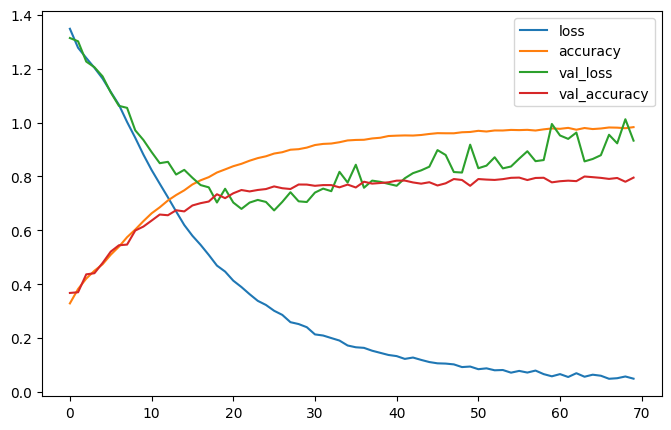

Results for fold 2
Epoch 1/70
270/270 [==============================] - ETA: 0s - loss: 1.3396 - accuracy: 0.3318

In [ ]:
val_res = {'accuracy': [], 'f1_score': [], 'confusion_matrix': []}
foldNum=0
#model = get_model()
for train_index, val_index in kfold.split(X_train, Y_train):
  foldNum = foldNum + 1
  model = get_model_tan()
  print("Results for fold",foldNum)
  x_train, x_val = X_train[train_index], X_train[val_index]
  y_train, y_val = Y_train[train_index], Y_train[val_index]
  class_weight = call_class_weights(y_train)
  history = model.fit(x_train, y_train, epochs=epochs, class_weight=class_weight, batch_size=batch_size, verbose=1, validation_data=(x_val, y_val),shuffle=True)
  acc = model.evaluate(x_test, y_test)
  print(acc)
  val_res['accuracy'].append(acc)
  pred = model.predict(x_test)
  f1scr = f1_score(y_test.argmax(1), pred.argmax(1), average='macro')
  print(f1scr)
  pd.DataFrame(history.history).plot(figsize=(8,5))
  plt.show()
  val_res['f1_score'].append(f1scr)
  val_res['confusion_matrix'].append(confusion_matrix(y_test.argmax(1), pred.argmax(1)))
  gc.collect() # Garbage collecter
  del x_train, x_val, y_train, y_val, acc, f1scr
  gc.collect()

Results for fold 1
Epoch 1/70
486/486 [==============================] - 39s 61ms/step - loss: 1.3029 - accuracy: 0.3630 - val_loss: 1.2437 - val_accuracy: 0.4184
Epoch 2/70
486/486 [==============================] - 30s 61ms/step - loss: 1.1977 - accuracy: 0.4531 - val_loss: 1.1271 - val_accuracy: 0.5127
Epoch 3/70
486/486 [==============================] - 29s 59ms/step - loss: 1.0884 - accuracy: 0.5206 - val_loss: 1.0035 - val_accuracy: 0.5741
Epoch 4/70
486/486 [==============================] - 29s 60ms/step - loss: 0.9585 - accuracy: 0.5930 - val_loss: 0.9066 - val_accuracy: 0.6241
Epoch 5/70
486/486 [==============================] - 29s 60ms/step - loss: 0.8443 - accuracy: 0.6463 - val_loss: 0.8041 - val_accuracy: 0.6713
Epoch 6/70
486/486 [==============================] - 30s 61ms/step - loss: 0.7514 - accuracy: 0.6955 - val_loss: 0.7325 - val_accuracy: 0.7121
Epoch 7/70
486/486 [==============================] - 29s 60ms/step - loss: 0.6756 - accuracy: 0.7264 - val_loss: 0.6

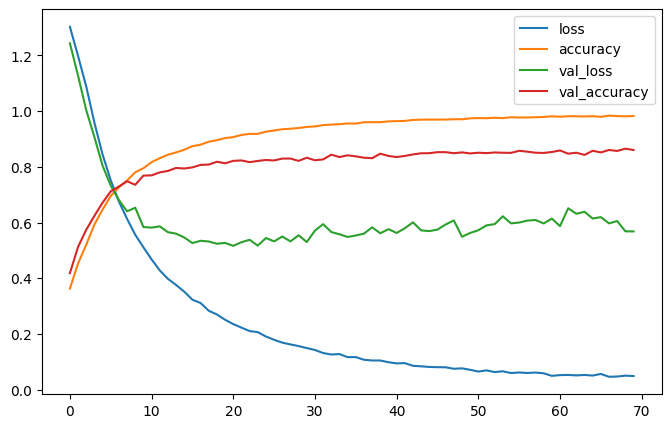

Results for fold 2
Epoch 1/70
486/486 [==============================] - 39s 62ms/step - loss: 1.3108 - accuracy: 0.3492 - val_loss: 1.2879 - val_accuracy: 0.3741
Epoch 2/70
486/486 [==============================] - 29s 61ms/step - loss: 1.2099 - accuracy: 0.4343 - val_loss: 1.1678 - val_accuracy: 0.4763
Epoch 3/70
486/486 [==============================] - 29s 60ms/step - loss: 1.0949 - accuracy: 0.5133 - val_loss: 1.0487 - val_accuracy: 0.5561
Epoch 4/70
486/486 [==============================] - 29s 60ms/step - loss: 0.9662 - accuracy: 0.5850 - val_loss: 0.9217 - val_accuracy: 0.6175
Epoch 5/70
486/486 [==============================] - 29s 60ms/step - loss: 0.8500 - accuracy: 0.6414 - val_loss: 0.9133 - val_accuracy: 0.6128
Epoch 6/70
486/486 [==============================] - 29s 60ms/step - loss: 0.7605 - accuracy: 0.6833 - val_loss: 0.7950 - val_accuracy: 0.6791
Epoch 7/70
486/486 [==============================] - 30s 61ms/step - loss: 0.6876 - accuracy: 0.7178 - val_loss: 0.7

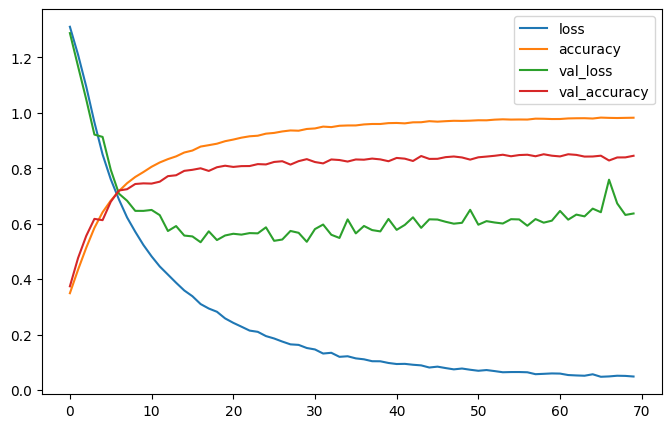

Results for fold 3
Epoch 1/70
486/486 [==============================] - 39s 62ms/step - loss: 1.3071 - accuracy: 0.3565 - val_loss: 1.2246 - val_accuracy: 0.4459
Epoch 2/70
486/486 [==============================] - 30s 62ms/step - loss: 1.2118 - accuracy: 0.4421 - val_loss: 1.1402 - val_accuracy: 0.4899
Epoch 3/70
486/486 [==============================] - 29s 60ms/step - loss: 1.1110 - accuracy: 0.5087 - val_loss: 1.0472 - val_accuracy: 0.5477
Epoch 4/70
486/486 [==============================] - 30s 61ms/step - loss: 0.9841 - accuracy: 0.5805 - val_loss: 0.9219 - val_accuracy: 0.6143
Epoch 5/70
486/486 [==============================] - 29s 60ms/step - loss: 0.8651 - accuracy: 0.6420 - val_loss: 0.8323 - val_accuracy: 0.6612
Epoch 6/70
486/486 [==============================] - 30s 61ms/step - loss: 0.7654 - accuracy: 0.6862 - val_loss: 0.8295 - val_accuracy: 0.6551
Epoch 7/70
486/486 [==============================] - 29s 60ms/step - loss: 0.6855 - accuracy: 0.7229 - val_loss: 0.7

KeyboardInterrupt: ignored

In [ ]:
val_res = {'accuracy': [], 'f1_score': [], 'confusion_matrix': []}
foldNum=0
#model = get_model()
for train_index, val_index in kfold.split(X_train, Y_train):
  foldNum = foldNum + 1
  model = get_model()
  print("Results for fold",foldNum)
  x_train, x_val = X_train[train_index], X_train[val_index]
  y_train, y_val = Y_train[train_index], Y_train[val_index]
  class_weight = call_class_weights(y_train)
  history = model.fit(x_train, y_train, epochs=epochs, class_weight=class_weight, batch_size=batch_size, verbose=1, validation_data=(x_val, y_val),shuffle=True)
  acc = model.evaluate(x_test, y_test)
  print(acc)
  val_res['accuracy'].append(acc)
  pred = model.predict(x_test)
  f1scr = f1_score(y_test.argmax(1), pred.argmax(1), average='macro')
  print(f1scr)
  pd.DataFrame(history.history).plot(figsize=(8,5))
  plt.show()
  val_res['f1_score'].append(f1scr)
  val_res['confusion_matrix'].append(confusion_matrix(y_test.argmax(1), pred.argmax(1)))
  gc.collect() # Garbage collecter
  del x_train, x_val, y_train, y_val, acc, f1scr
  gc.collect()

Accuracy  : 0.9149999916553497
F1_Score  : 0.9127174711685322


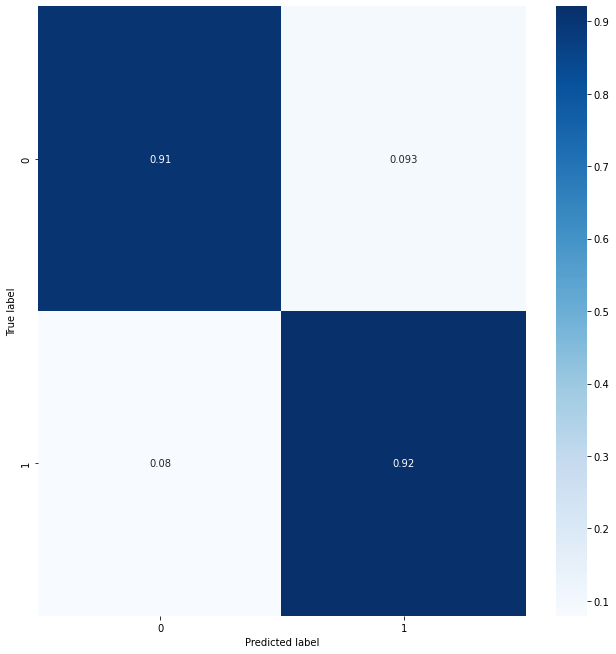

In [ ]:
#50 epochs
acrc = np.array(val_res['accuracy']).mean(axis=0)
f1scr = np.array(val_res['f1_score']).mean(axis=0)
print("Accuracy  : {}".format(acrc[1]))
print("F1_Score  : {}".format(f1scr))
cmatrix = np.array(val_res['confusion_matrix']).mean(axis=0)
c_matrix = cmatrix/np.sum(cmatrix, axis=1).reshape(2,1)
import seaborn as sns
figure = plt.figure(figsize=(9, 9))
sns.heatmap(c_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()